### Importar librerias

In [30]:
import os
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import storage

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Configuración de la conexión con GCP

#### Crear un cliente de BigQuery

In [31]:

# Configurar la variable de entorno
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/nicolascalarco/.ssh/analitica1.json"

# Leer las credenciales de la variable de entorno
credentials = service_account.Credentials.from_service_account_file(os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

# Crear el cliente de BigQuery con las credenciales
client = bigquery.Client(project='analitica-1-383323', credentials=credentials)

In [32]:
# Armado de consulta para trabajar con los datos
sql = """
SELECT 
id,
antiguedad_meses,
CASE
when antiguedad_meses>=0 and antiguedad_meses<6 then 0
when antiguedad_meses>=6 and antiguedad_meses<(select avg(antiguedad_meses) from `analitica-1-383323.ecomm.users`) then 1
else 2
end as antiguedad_cliente,		
fuga	,		
ind_satisfaccion,		

case
when var_is<0 then -1
when var_is=0 then 0
when var_is>0 then 1
end as satisfaccion_stuacion,
nro_casos_soporte,		
var_nro_casos_soporte	,	
if(nro_casos_soporte=0 and var_nro_casos_soporte=0,0,1) as tuvo_problemas,
case
when var_nro_casos_soporte>0 then -1
when var_nro_casos_soporte=0 then 0
when var_nro_casos_soporte<0 then 1
end as soporte_situacion,	
prioridad_soporte	,
case
when prioridad_soporte>=0 and prioridad_soporte<2 then 0
when prioridad_soporte>=2 and prioridad_soporte<3 then -1
when prioridad_soporte>=3 then -2
end as prioridad_soporte_situacion,
var_prioridad_soporte	,		
var_nro_login	,		
var_uso_servicio	,		
var_beneficio_usuario	,		
var_dias_ult_conexion	,
if(var_dias_ult_conexion>-1,-1,0) as conexion_ultimo_mes
FROM `analitica-1-383323.ecomm.users`
"""
query_job = client.query(sql)
data = query_job.result().to_dataframe()


In [12]:
#Configurando el entorno de trabajo
project_id = 'analitica-1-383323'
dataset_name = 'ecomm'
table_name = 'users_final'

# Especifica la tabla de destino en BigQuery
destination_table = f"{project_id}.{dataset_name}.{table_name}"

# Guarda el DataFrame en BigQuery, reemplazando la tabla existente (si existe)
data.to_gbq(destination_table, project_id=project_id, if_exists='replace', credentials=credentials)

# Guardar el DataFrame en un archivo CSV
data.to_csv('../data/universo.csv', index=False)


100%|██████████| 1/1 [00:00<00:00, 1468.59it/s]


#### Analizar el dataset


In [36]:
# Metricas de evaluacion y estadisticas sobre el dataframe generado
data.describe()

,id,antiguedad_meses,antiguedad_cliente,fuga,ind_satisfaccion,satisfaccion_stuacion,nro_casos_soporte,var_nro_casos_soporte,tuvo_problemas,soporte_situacion,prioridad_soporte,prioridad_soporte_situacion,var_prioridad_soporte,var_nro_login,var_uso_servicio,var_beneficio_usuario,var_dias_ult_conexion,conexion_ultimo_mes
count,2012.0,2012.0,2012.0,2012.000000,2012.000000,2012.0,2012.000000,2012.000000,2012.0,2012.0,2012.000000,2012.0,2012.000000,2012.000000,2012.000000,2012.000000,2012.000000,2012.0
mean,1006.5,28.184891,1.262425,0.047217,173.553678,0.017893,1.360835,-0.080517,0.388171,-0.007455,0.806895,-0.513419,0.048526,29.352883,0.293241,107.628231,1.455765,-0.75
std,580.95869,22.793074,0.65677,0.212155,131.827086,0.883957,3.254652,3.588960,0.487455,0.594559,1.317088,0.852246,1.428560,75.906881,6.165583,2084.298004,21.286764,0.43312
min,1.0,0.0,0.0,0.000000,0.000000,-1.0,0.000000,-32.000000,0.0,-1.0,0.000000,-2.0,-4.000000,-224.000000,-86.000000,-25950.000000,-648.000000,-1.0
25%,503.75,10.0,1.0,0.000000,48.000000,-1.0,0.000000,0.000000,0.0,0.0,0.000000,-1.0,0.000000,-2.000000,0.000000,-36.500000,-0.250000,-1.0
50%,1006.5,22.0,1.0,0.000000,175.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,-1.0
75%,1509.25,42.0,2.0,0.000000,274.000000,1.0,2.000000,0.000000,1.0,0.0,2.500000,0.0,0.000000,44.000000,0.000000,44.000000,3.000000,-0.75
max,2012.0,134.0,2.0,1.000000,580.000000,1.0,36.000000,26.000000,1.0,1.0,4.000000,0.0,4.000000,706.000000,102.000000,29736.000000,31.000000,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           2012 non-null   Int64  
 1   antiguedad_meses             2012 non-null   Int64  
 2   antiguedad_cliente           2012 non-null   Int64  
 3   fuga                         2012 non-null   float64
 4   ind_satisfaccion             2012 non-null   float64
 5   satisfaccion_stuacion        2012 non-null   Int64  
 6   nro_casos_soporte            2012 non-null   float64
 7   var_nro_casos_soporte        2012 non-null   float64
 8   tuvo_problemas               2012 non-null   Int64  
 9   soporte_situacion            2012 non-null   Int64  
 10  prioridad_soporte            2012 non-null   float64
 11  prioridad_soporte_situacion  2012 non-null   Int64  
 12  var_prioridad_soporte        2012 non-null   float64
 13  var_nro_login     

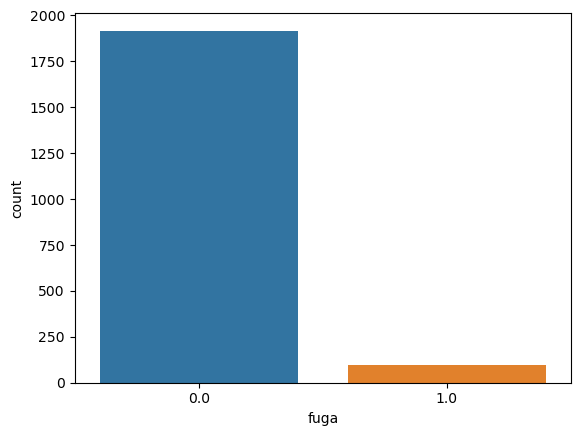

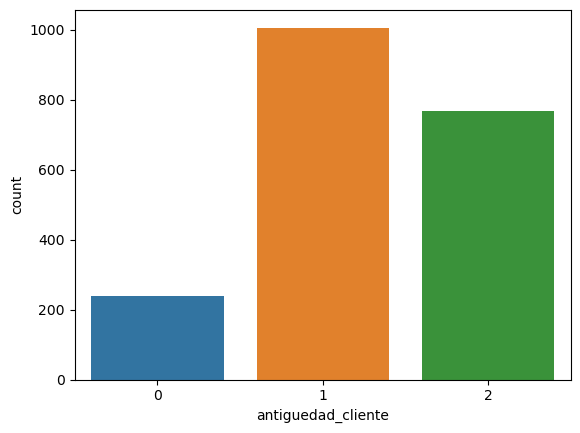

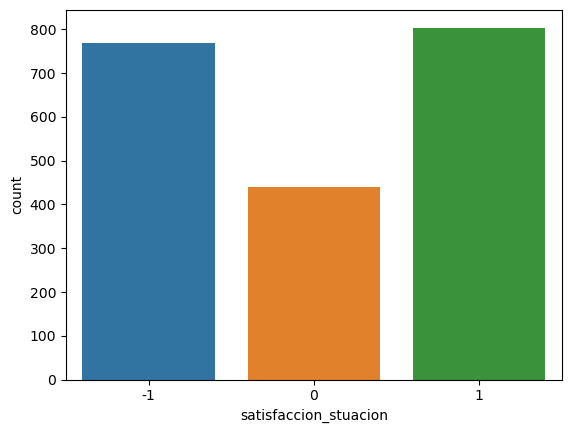

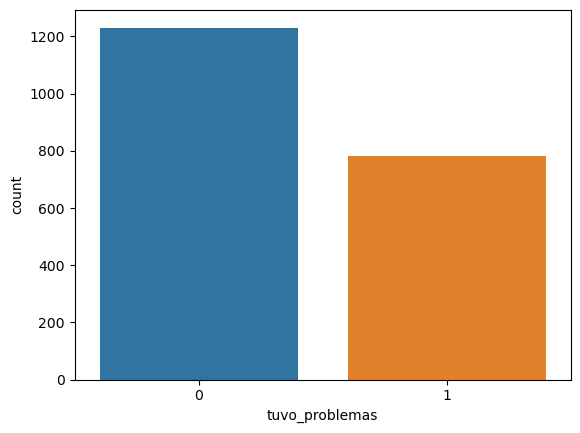

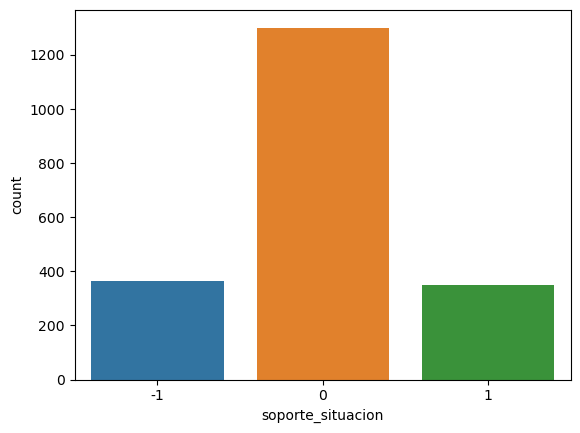

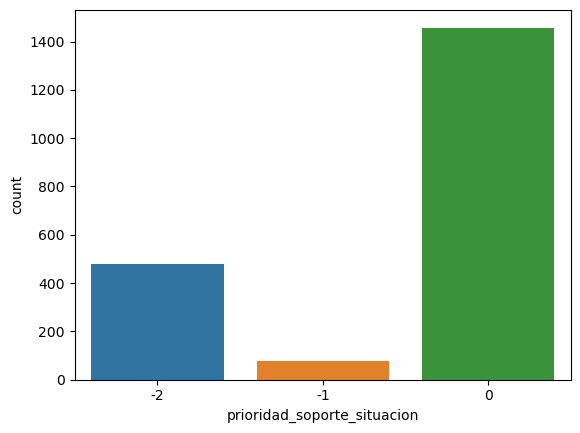

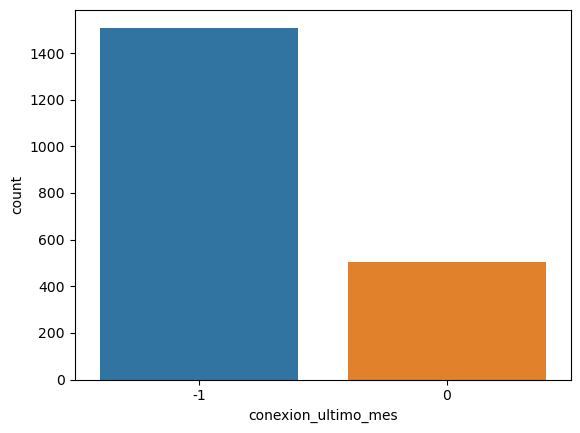

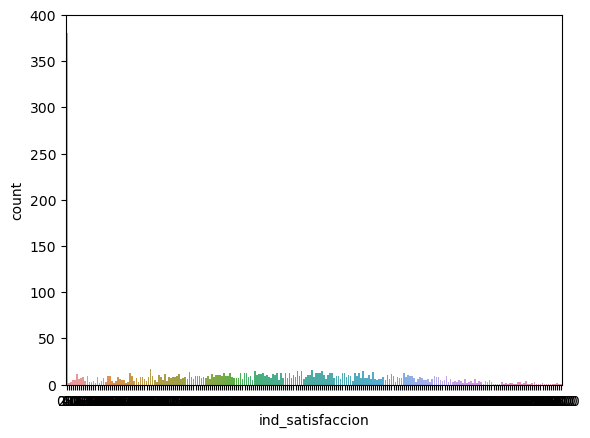

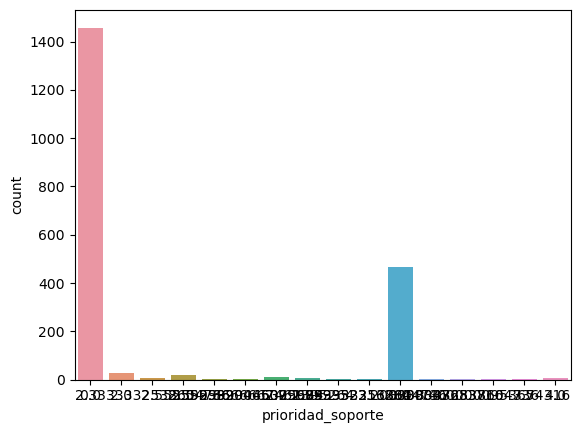

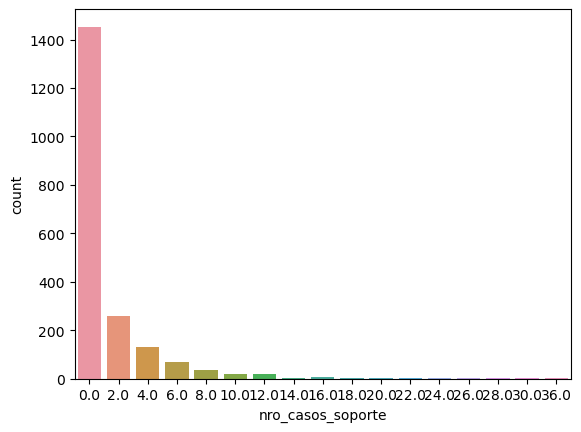

In [37]:
# Metricas de evaluacion y estadisticas sobre el dataframe generado
print(data.info())

# Grafico de barras para la variable fuga
sns.countplot(x='fuga', data=data)
plt.show()

# Grafico de barras para la variable antiguedad_cliente
sns.countplot(x='antiguedad_cliente', data=data)
plt.show()

# Grafico de barras para la variable satisfaccion_stuacion
sns.countplot(x='satisfaccion_stuacion', data=data)
plt.show()

# Grafico de barras para la variable tuvo_problemas
sns.countplot(x='tuvo_problemas', data=data)
plt.show()

# Grafico de barras para la variable soporte_situacion
sns.countplot(x='soporte_situacion', data=data)
plt.show()

# Grafico de barras para la variable prioridad_soporte_situacion
sns.countplot(x='prioridad_soporte_situacion', data=data)
plt.show()

# Grafico de barras para la variable conexion_ultimo_mes
sns.countplot(x='conexion_ultimo_mes', data=data)
plt.show()

# Grafico de barras para la variable ind_satisfaccion
sns.countplot(x='ind_satisfaccion', data=data)
plt.show()

# Grafico de barras para la variable prioridad_soporte
sns.countplot(x='prioridad_soporte', data=data)
plt.show()

# Grafico de barras para la variable nro_casos_soporte
sns.countplot(x='nro_casos_soporte', data=data)
plt.show()


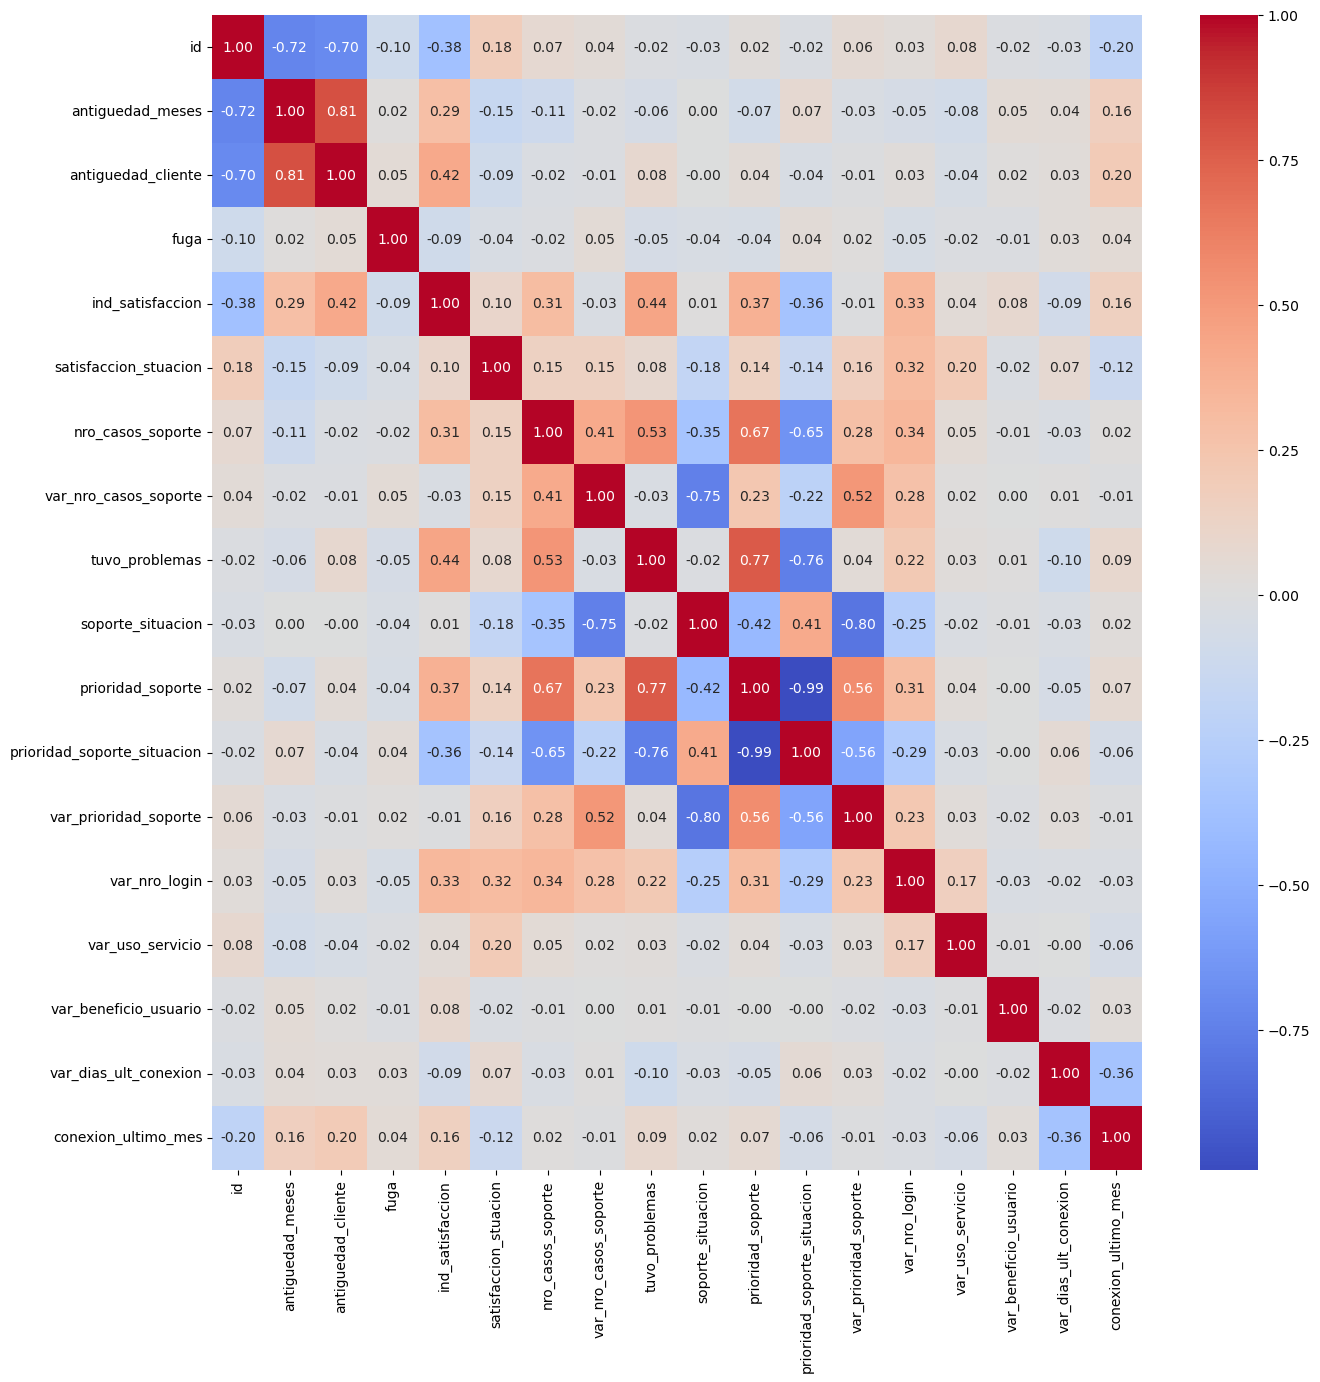

In [27]:
#Correlacion entre las variables fuga y las demas.
corr = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

#guardar imagen en "./output/correlacion.png"
plt.savefig('../output/correlacion.png')
plt.show()


In [33]:
#Exportar información a Storage Bucket de Google Cloud
bucket_name = 'challenger_ecomm'
source_file_name = '../output/correlacion.png'
destination_blob_name = 'user/correlacion/analisis.png'

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)

# Hacer que la imagen sea accesible públicamente
blob.make_public()

public_url = blob.public_url
print(f"File {source_file_name} uploaded to {destination_blob_name}.")
print(f"Public URL: {public_url}")



File ../output/correlacion.png uploaded to user/correlacion/analisis.png.
Public URL: https://storage.googleapis.com/challenger_ecomm/user/correlacion/analisis.png
